In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

#To know what is the last date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#last_date
#Last date - one year
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
query_date

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date,Measurement.prcp]
queryresult = session.query(*sel).filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precipitation_df = pd.DataFrame(queryresult, columns=['Date','Precipitation'])
precipitation_df = precipitation_df.dropna(how='any')
precipitation_df = precipitation_df.sort_values(["Date"], ascending=True)
precipitation_df = precipitation_df.set_index("Date")
precipitation_df



,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


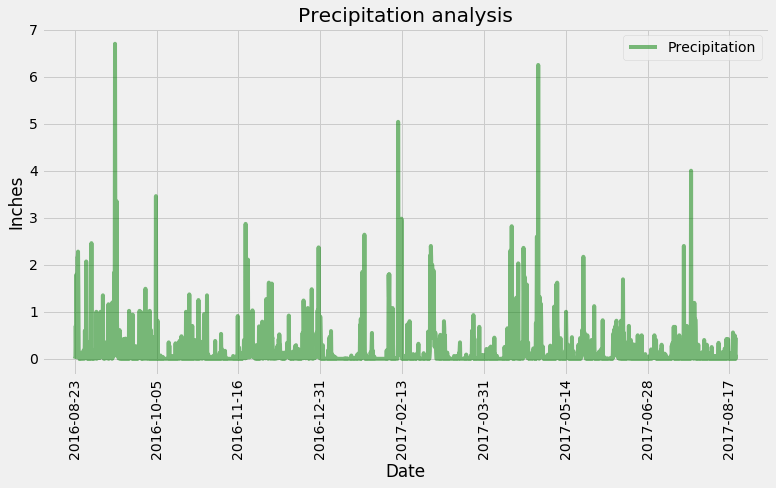

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(figsize=(11,7),color='g',alpha=0.5)
plt.title("Precipitation analysis")
plt.ylabel('Inches')
plt.xticks(rotation='90')
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station,func.count(Measurement.id)]
active_stations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

sel = [Measurement.station,func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
station_data = session.query(*sel).filter(Measurement.station == active_stations[0][0]).\
    group_by(Measurement.station).all()
    
station_data

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

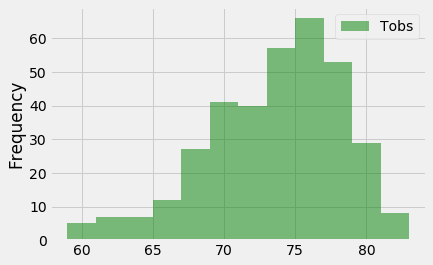

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

highest_station_year = session.query(Measurement.date, Measurement.tobs).\
                    filter(Measurement.station == active_stations[0][0]).\
                    filter(Measurement.date >= query_date).\
                    order_by(Measurement.date).all()

#highest_station_year
highest_station_year_df = pd.DataFrame(highest_station_year, columns=['Date','Tobs'])
highest_station_year_df = highest_station_year_df.dropna(how='any') 
highest_station_year_df = highest_station_year_df.sort_index(ascending=True)
highest_station_year_df.plot(kind='hist', bins=12, color='g',alpha=0.5)

## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_data = calc_temps('2016-10-05','2016-10-12')
print(trip_data)

[(71.0, 77.48, 82.0)]


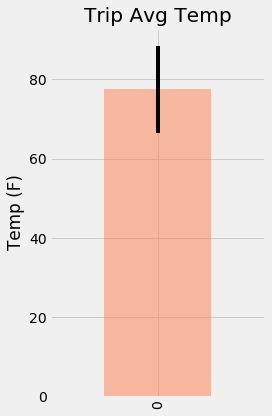

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_data_df = pd.DataFrame(trip_data, columns=['tmin', 'tavg', 'tmax'])

trip_data_df.plot.bar(y='tavg', yerr=(trip_data_df['tmax'] - trip_data_df['tmin']),color='coral', alpha=0.5, figsize=(4,6), title='Trip Avg Temp')

#plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()

plt.show()

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2016-10-05'
end_date ='2016-10-12'

# Use the start and end date to create a range of dates
dates_lookup = session.query(Measurement.date).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).\
        group_by(Measurement.date).all()

trip_dates_range = [x[0] for x in dates_lookup]

trip_dates_stripped= [x[5:] for x in trip_dates_range]

start_m_day = trip_dates_stripped[0]
end_m_day = trip_dates_stripped[-1]

# Loop through the list of %m-%d strings and calculate the normals for each date

daily_normals = [session.query(func.min(Measurement.tobs),
                       func.avg(Measurement.tobs),
                       func.max(Measurement.tobs)).
                       filter(func.strftime("%m-%d", Measurement.date) >= start_m_day).
                       filter(func.strftime("%m-%d", Measurement.date) <= end_m_day).
                       group_by(func.strftime("%m-%d", Measurement.date)).all()]

daily_normals = daily_normals[0]
daily_normals


[(67.0, 76.16666666666667, 84.0),
 (70.0, 75.42, 81.0),
 (68.0, 75.6078431372549, 81.0),
 (66.0, 76.3265306122449, 86.0),
 (69.0, 76.11363636363636, 84.0),
 (69.0, 75.85416666666667, 83.0),
 (69.0, 76.57142857142857, 84.0),
 (65.0, 75.75510204081633, 82.0)]

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

daily_normals_df= pd.DataFrame(daily_normals,columns=['tmin', 'tavg', 'tmax'])

daily_normals_df['date']= trip_dates_range
daily_normals_df['date'] = pd.to_datetime(daily_normals_df['date'], format='%Y-%m-%d')
daily_normals_df.set_index('date',inplace=True)

daily_normals_df

,tmin,tavg,tmax
date,,,
2016-10-05,67.0,76.166667,84.0
2016-10-06,70.0,75.420000,81.0
2016-10-07,68.0,75.607843,81.0
2016-10-08,66.0,76.326531,86.0
2016-10-09,69.0,76.113636,84.0
2016-10-10,69.0,75.854167,83.0
2016-10-11,69.0,76.571429,84.0
2016-10-12,65.0,75.755102,82.0


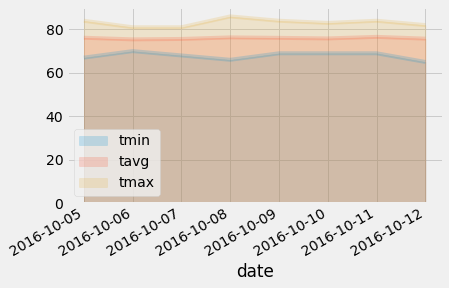

In [24]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot.area(alpha=.2, stacked=False, x_compat=True)
